<a href="https://colab.research.google.com/github/abxda/UP_Python_2025/blob/main/Semana_05_01_Lunes_UP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este cuaderno demuestra un flujo de trabajo completo para:
1. Recopilar noticias utilizando la búsqueda de DuckDuckGo.
2. Preprocesar el texto de las noticias (limpieza, eliminación de stopwords, lematización).
3. Realizar un análisis exploratorio básico (nube de palabras, distribución de fuentes).
4. Aplicar técnicas de clustering (K-Means) para agrupar noticias similares.
5. Visualizar los resultados de los clusters.

In [ ]:
# ==============================================================================
# SECCIÓN 1: INSTALACIÓN Y CONFIGURACIÓN DE BIBLIOTECAS
# ==============================================================================
# En esta sección, instalamos todas las bibliotecas necesarias para el análisis.
# Es una buena práctica agrupar todas las instalaciones al principio.
# El modificador '-q' se usa para una instalación "silenciosa" (menos output).
# ------------------------------------------------------------------------------

!pip install -q -U duckduckgo_search  # Asegura la última versión
!pip install -q wordcloud matplotlib pandas
!pip install -q -U spacy
!python -m spacy download es_core_news_sm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 66.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
#REINICIAR SESION

In [6]:
# ------------------------------------------------------------------------------
# Importación de bibliotecas
# ------------------------------------------------------------------------------
import string       # Para manipulación de cadenas (eliminar puntuación)
import pandas as pd # Para manipulación de datos tabulares (DataFrames)
import nltk         # Natural Language Toolkit, para procesamiento de lenguaje natural
from nltk.corpus import stopwords # Lista de palabras comunes a ignorar
import spacy        # Biblioteca avanzada para PLN, usada aquí para lematización
import matplotlib.pyplot as plt # Para crear visualizaciones
from wordcloud import WordCloud # Para generar nubes de palabras

# Importaciones para la búsqueda de noticias y manejo de errores
from duckduckgo_search import DDGS
from duckduckgo_search.exceptions import DuckDuckGoSearchException

# Bibliotecas de Scikit-learn para Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [7]:
# ------------------------------------------------------------------------------
# Descarga de recursos adicionales para NLTK y carga de modelo spaCy
# ------------------------------------------------------------------------------
try:
    stopwords.words('spanish')
except LookupError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

# Cargamos el modelo pequeño de spaCy para español.
nlp_es = spacy.load("es_core_news_sm")

print("Bibliotecas instaladas, importadas y recursos descargados.")

Bibliotecas instaladas, importadas y recursos descargados.


In [8]:
# ==============================================================================
# SECCIÓN 2: RECOPILACIÓN DE NOTICIAS (Síncrono)
# ==============================================================================
# Usaremos la clase DDGS de la biblioteca duckduckgo_search de forma síncrona.
# ------------------------------------------------------------------------------

# Configuración para la búsqueda de noticias.
configuracion_busqueda = {
    "keywords": "Aguascalientes",
    "region": "mx-es",      # México, en español
    "max_results": 100,     # Número máximo de noticias a obtener
    "safesearch": "moderate", # Opciones: 'on', 'moderate', 'off'
    "timelimit": None       # Opciones: 'd' (día), 'w' (semana), 'm' (mes), None (sin límite)
}


In [9]:
# Lista para almacenar los resultados de las noticias.
resultados_noticias_raw = []

def buscar_noticias_sincrono(keywords, region, max_results, safesearch='moderate', timelimit=None):
    """
    Función síncrona para buscar noticias utilizando DDGS().news().
    """
    print(f"Iniciando búsqueda de noticias para: '{keywords}' en región '{region}' (max: {max_results}, safesearch: {safesearch})...")
    ddgs_instance = DDGS(timeout=20) # Timeout de 20 segundos.
    try:
        noticias = ddgs_instance.news(
            keywords=keywords,
            region=region,
            safesearch=safesearch,
            timelimit=timelimit,
            max_results=max_results
        )
        print(f"Búsqueda completada. Se encontraron {len(noticias)} noticias.")
        return noticias
    except DuckDuckGoSearchException as e:
        print(f"Error durante la búsqueda de noticias con DuckDuckGo: {e}")
        return []
    except Exception as e:
        print(f"Ocurrió un error inesperado durante la búsqueda de noticias: {e}")
        return []

def ejecutar_busqueda_principal_sincrono():
    """
    Función principal síncrona para coordinar la búsqueda de noticias.
    """
    global resultados_noticias_raw
    print("Ejecutando búsqueda principal de noticias (modo síncrono)...")
    noticias_encontradas = buscar_noticias_sincrono(
        keywords=configuracion_busqueda['keywords'],
        region=configuracion_busqueda['region'],
        max_results=configuracion_busqueda['max_results'],
        safesearch=configuracion_busqueda['safesearch'],
        timelimit=configuracion_busqueda['timelimit']
    )
    resultados_noticias_raw.extend(noticias_encontradas)

    if resultados_noticias_raw:
        print(f"\nTotal de noticias recopiladas: {len(resultados_noticias_raw)}")
        print("Primeras 5 noticias (títulos):")
        for i, noticia in enumerate(resultados_noticias_raw[:5]):
            print(f"  {i+1}. {noticia.get('title', 'N/A')}")
    else:
        print("No se encontraron noticias o ocurrió un error durante la búsqueda.")


In [10]:
# ------------------------------------------------------------------------------
# Ejecución de la búsqueda de noticias (llamada síncrona directa)
# ------------------------------------------------------------------------------
ejecutar_busqueda_principal_sincrono()


Ejecutando búsqueda principal de noticias (modo síncrono)...
Iniciando búsqueda de noticias para: 'Aguascalientes' en región 'mx-es' (max: 100, safesearch: moderate)...
Búsqueda completada. Se encontraron 100 noticias.

Total de noticias recopiladas: 100
Primeras 5 noticias (títulos):
  1. NISSAN Aguascalientes podría estar entre las plantas automotrices que cerrarán sus puertas
  2. MIYM anuncia inversión de mil 100 mdp en Aguascalientes: habrá más de 2 mil empleos
  3. Estas son las veces que el Congreso de Aguascalientes frenó iniciativas contra el maltrato animal
  4. Distribuidor de droga crystal enfrenta un proceso penal federal recluido en el CERESO Aguascalientes
  5. Ganó parralense medalla en el Nacional de Natación en Aguascalientes


In [11]:
# ==============================================================================
# SECCIÓN 3: CONVERSIÓN A DATAFRAME Y EXPLORACIÓN INICIAL
# ==============================================================================
# Convertimos la lista de diccionarios de noticias en un DataFrame de Pandas.
# ------------------------------------------------------------------------------

if resultados_noticias_raw:
    df_noticias = pd.DataFrame(resultados_noticias_raw)
    print(f"\nDataFrame creado con {df_noticias.shape[0]} filas y {df_noticias.shape[1]} columnas.")
    print("\nPrimeras filas del DataFrame:")
    display(df_noticias.head())
    print("\nInformación del DataFrame:")
    df_noticias.info()
    print("\nColumnas disponibles:", df_noticias.columns.tolist())
else:
    print("No hay noticias para crear el DataFrame. El cuaderno no puede continuar sin datos.")
    df_noticias = pd.DataFrame()



DataFrame creado con 100 filas y 6 columnas.

Primeras filas del DataFrame:


,date,title,body,url,image,source
0,2025-05-19T06:44:00+00:00,NISSAN Aguascalientes podría estar entre las p...,Han comenzado las especulaciones en torno al p...,https://www.lja.mx/2025/05/nissan-aguascalient...,https://www.lja.mx/wp-content/uploads/2025/05/...,LJA Aguascalientes
1,2025-05-19T01:29:05+00:00,MIYM anuncia inversión de mil 100 mdp en Aguas...,Con una inversión aproximada de mil 100 millon...,https://www.msn.com/es-mx/dinero/noticias/miym...,https://newsweekespanol.com/wp-content/uploads...,Newsweek México
2,2025-05-19T01:27:43+00:00,Estas son las veces que el Congreso de Aguasca...,Luego de varias legislaturas en las que se rec...,https://www.msn.com/es-mx/noticias/mexico/esta...,https://newsweekespanol.com/wp-content/uploads...,Newsweek México
3,2025-05-19T18:51:00+00:00,Distribuidor de droga crystal enfrenta un proc...,Un presunto distribuidor de droga crystal enfr...,https://aguasdigital.com/2025/05/19/distribuid...,https://aguasdigital.com/wp-content/uploads/20...,¡El Aguas!
4,2025-05-19T14:10:00+00:00,Ganó parralense medalla en el Nacional de Nata...,"Por primera vez en la historia, el equipo de n...",https://www.tiempo.com.mx/noticia/parralence_a...,https://static.tiempo.com.mx/uploads/imagen/im...,Tiempo La Noticia Digital



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    100 non-null    object
 1   title   100 non-null    object
 2   body    100 non-null    object
 3   url     100 non-null    object
 4   image   100 non-null    object
 5   source  100 non-null    object
dtypes: object(6)
memory usage: 4.8+ KB

Columnas disponibles: ['date', 'title', 'body', 'url', 'image', 'source']



Análisis de fuentes de noticias:
source
LJA Aguascalientes              43
Newsweek México                 13
El Heraldo de Aguascalientes     5
OEM                              5
Debate                           5
El Clarinete                     3
Milenio                          3
Página 24                        2
Indigo                           2
Reporte Índigo                   2
¡El Aguas!                       1
Radio Fórmula                    1
Municipios Puebla                1
Tiempo La Noticia Digital        1
Líder Empresarial                1
88.9 Noticias                    1
La Jornada                       1
DESDElared                       1
El Siglo de Torreón              1
El Diario                        1
Telediario México                1
Newsweek (Español)               1
El Heraldo de México             1
MILENIO                          1
mvsnoticias                      1
liderempresarial                 1
La Jornada Aguascalientes        1
Name: count, d

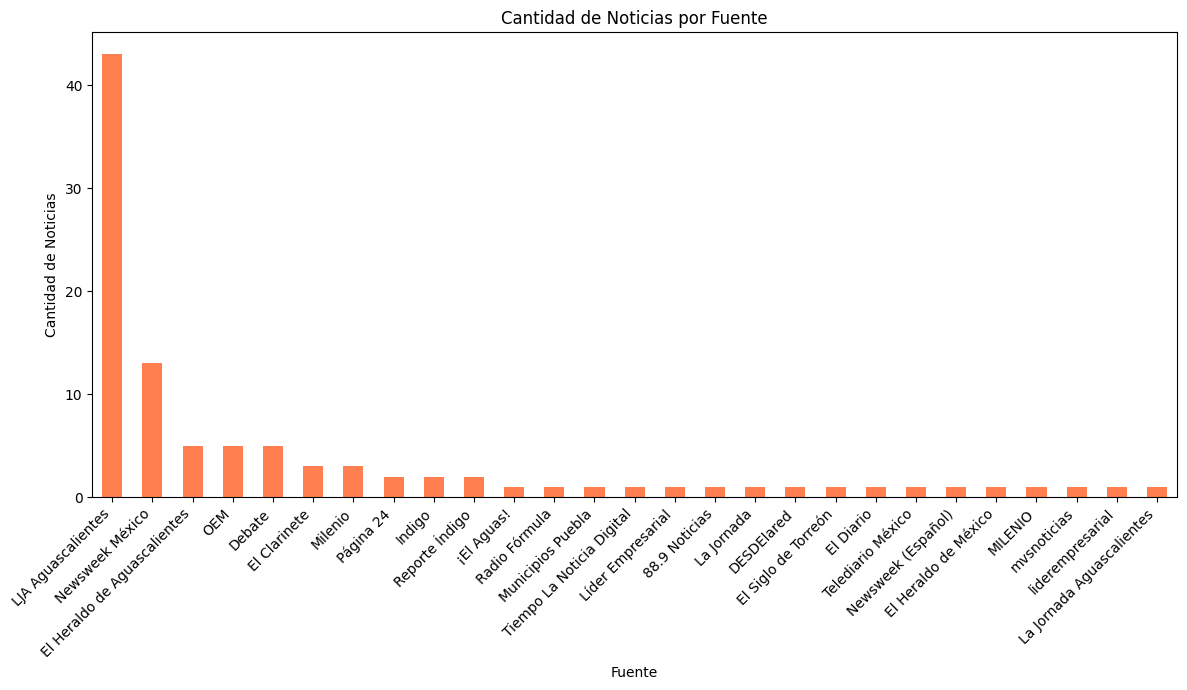

In [12]:
# ------------------------------------------------------------------------------
# Exploración inicial: Distribución de noticias por fuente
# ------------------------------------------------------------------------------
if not df_noticias.empty and 'source' in df_noticias.columns:
    print("\nAnálisis de fuentes de noticias:")
    conteo_fuentes = df_noticias['source'].value_counts()
    print(conteo_fuentes)

    plt.figure(figsize=(12, 7))
    conteo_fuentes.plot(kind='bar', color='coral') # Cambiado color
    plt.title('Cantidad de Noticias por Fuente')
    plt.xlabel('Fuente')
    plt.ylabel('Cantidad de Noticias')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No se puede generar el gráfico de fuentes: DataFrame vacío o sin columna 'source'.")


In [13]:
# ==============================================================================
# SECCIÓN 4: PREPROCESAMIENTO DEL TEXTO DE LAS NOTICIAS
# ==============================================================================
# Pasos: minúsculas, quitar puntuación, quitar stopwords, lematización.
# Se trabaja con la columna 'body'.
# ------------------------------------------------------------------------------

if not df_noticias.empty and 'body' in df_noticias.columns:
    df_noticias['body_original'] = df_noticias['body']
    df_noticias['body'] = df_noticias['body'].fillna('').astype(str)

    print("\nPaso 1: Convirtiendo texto a minúsculas...")
    df_noticias['texto_limpio'] = df_noticias['body'].str.lower()

    print("\nPaso 2: Eliminando signos de puntuación...")
    translator = str.maketrans('', '', string.punctuation + '¡¿“”‘’«»')
    df_noticias['texto_limpio'] = df_noticias['texto_limpio'].apply(lambda x: x.translate(translator))

    print("\nPaso 3: Eliminando stopwords en español...")
    stop_words_es = set(stopwords.words('spanish'))
    # stop_words_es.update(['aguascalientes', 'ciudad']) # Ejemplo de stopwords personalizadas

    def eliminar_stopwords(texto):
        palabras = texto.split()
        palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words_es]
        return ' '.join(palabras_filtradas)
    df_noticias['texto_limpio_sin_stopwords'] = df_noticias['texto_limpio'].apply(eliminar_stopwords)

    print("\nPaso 4: Lematizando el texto...")
    def lematizar_texto(texto):
        doc = nlp_es(texto)
        lemas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space and token.lemma_.strip()]
        return ' '.join(lemas)
    df_noticias['texto_lematizado'] = df_noticias['texto_limpio_sin_stopwords'].apply(lematizar_texto)

    df_noticias['texto_procesado_final'] = df_noticias['texto_lematizado']
    print("\nPreprocesamiento completado. Columna 'texto_procesado_final' lista.")
    display(df_noticias[['title', 'body_original', 'texto_procesado_final']].head())
else:
    print("No se puede realizar el preprocesamiento: DataFrame vacío o sin columna 'body'.")



Paso 1: Convirtiendo texto a minúsculas...

Paso 2: Eliminando signos de puntuación...

Paso 3: Eliminando stopwords en español...

Paso 4: Lematizando el texto...

Preprocesamiento completado. Columna 'texto_procesado_final' lista.


,title,body_original,texto_procesado_final
0,NISSAN Aguascalientes podría estar entre las p...,Han comenzado las especulaciones en torno al p...,comenzado especulación torno posible cerrar pl...
1,MIYM anuncia inversión de mil 100 mdp en Aguas...,Con una inversión aproximada de mil 100 millon...,inversión aproximado mil 100 millón peso gener...
2,Estas son las veces que el Congreso de Aguasca...,Luego de varias legislaturas en las que se rec...,luego varios legislatura rechazar iniciativa e...
3,Distribuidor de droga crystal enfrenta un proc...,Un presunto distribuidor de droga crystal enfr...,presunto distribuidor droga crystal enfrentar ...
4,Ganó parralense medalla en el Nacional de Nata...,"Por primera vez en la historia, el equipo de n...",primero vez historia equipo natación tiburón p...



Generando nube de palabras del texto procesado final...


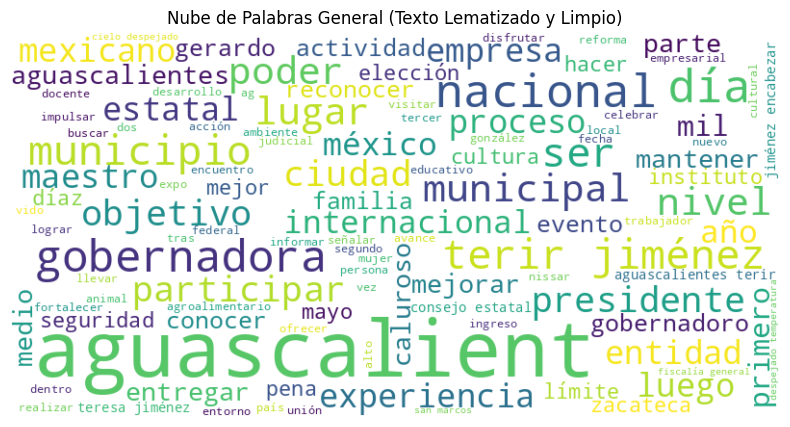

In [14]:
# ==============================================================================
# SECCIÓN 5: VISUALIZACIÓN CON NUBE DE PALABRAS
# ==============================================================================
# Muestra las palabras más frecuentes de forma visual.
# ------------------------------------------------------------------------------

def generar_nube_de_palabras_custom(textos_series, titulo="Nube de Palabras"):
    """
    Genera y muestra una nube de palabras a partir de una Serie de Pandas de textos.
    """
    if not textos_series.empty and textos_series.astype(str).str.strip().any():
        texto_completo = ' '.join(textos_series.dropna())
        if not texto_completo.strip():
            print(f"No hay texto significativo para generar la nube de palabras para '{titulo}'.")
            return

        wordcloud = WordCloud(
            width=800, height=400, background_color='white',
            stopwords=stop_words_es, min_font_size=10, collocations=True
        ).generate(texto_completo)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(titulo)
        plt.show()
    else:
        print(f"No se puede generar la nube de palabras para '{titulo}': no hay texto o está vacío.")

if not df_noticias.empty and 'texto_procesado_final' in df_noticias.columns:
    print("\nGenerando nube de palabras del texto procesado final...")
    generar_nube_de_palabras_custom(df_noticias['texto_procesado_final'],
                                    titulo="Nube de Palabras General (Texto Lematizado y Limpio)")
else:
    print("No se puede generar la nube de palabras general: DataFrame vacío o sin texto procesado.")



Iniciando Feature Engineering con TF-IDF...
Matriz TF-IDF creada con dimensiones: (100, 121)

Aplicando K-Means para encontrar 5 clusters...

Clusters asignados. Conteo de noticias por cluster:
cluster_id
0.0     8
1.0    54
2.0    15
3.0     8
4.0    15
Name: count, dtype: int64

Generando visualizaciones para cada cluster...


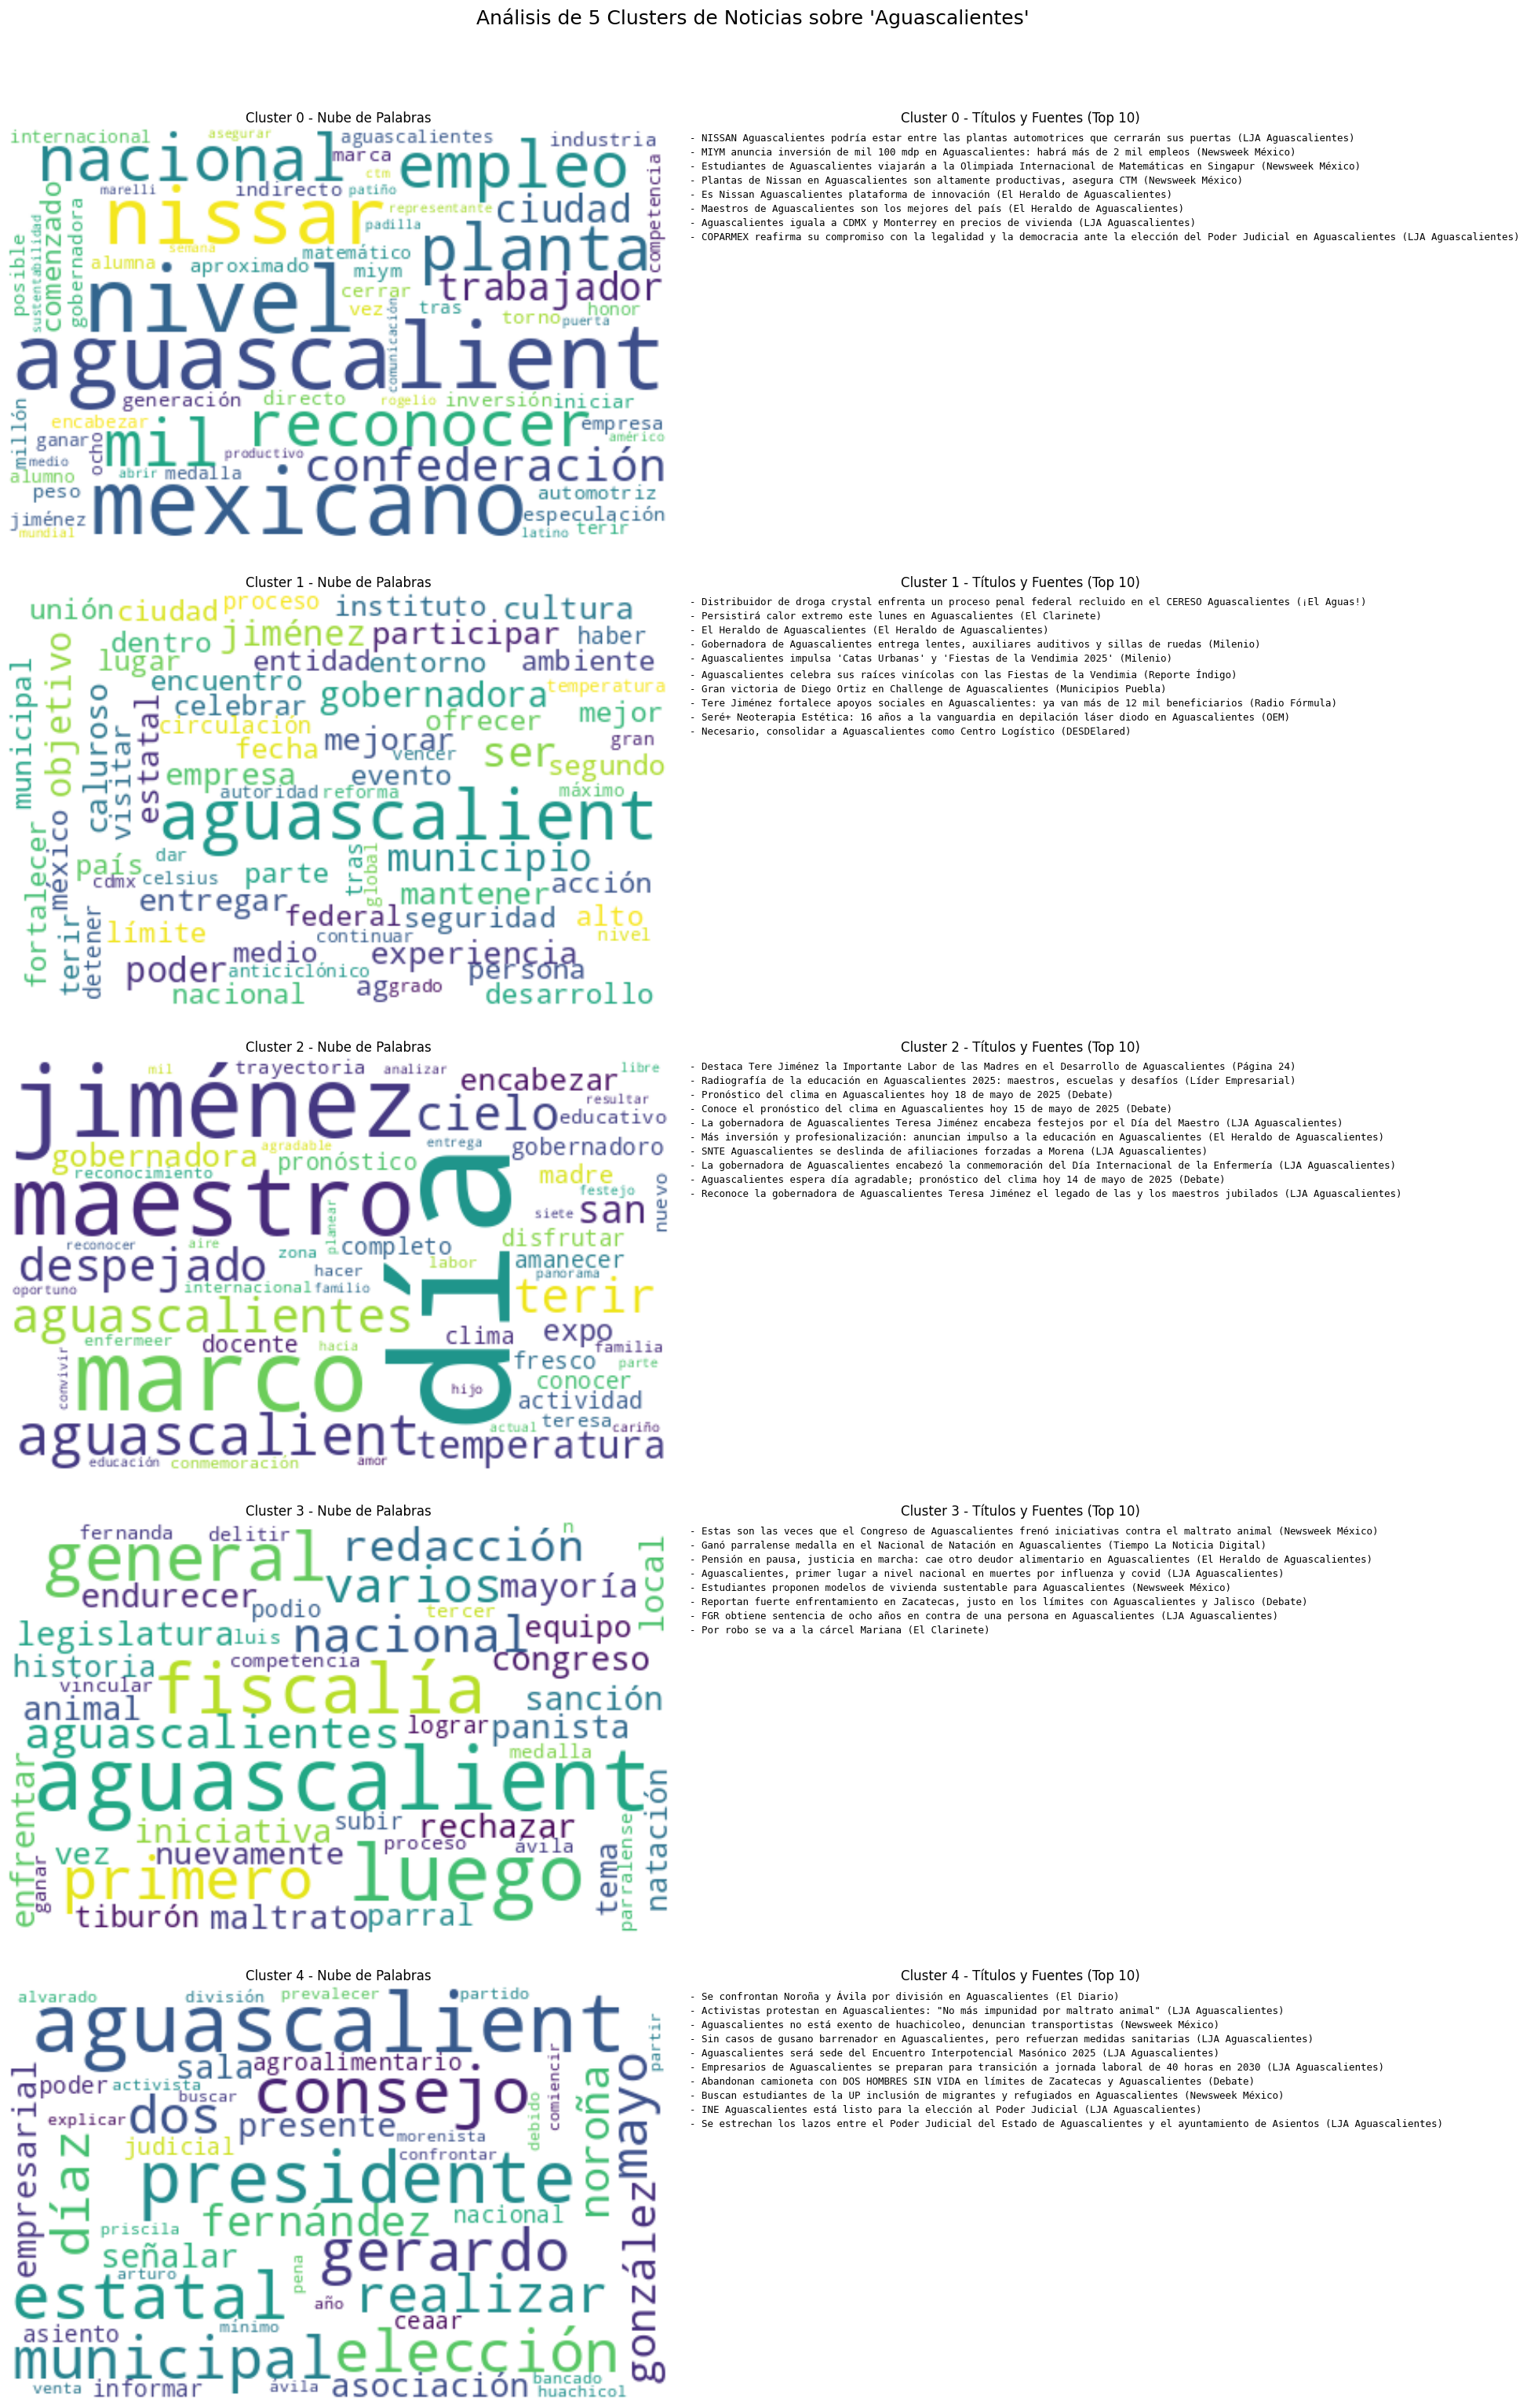


--- Análisis de Clusters Completado ---


In [17]:
# ==============================================================================
# SECCIÓN 6: FEATURE ENGINEERING (TF-IDF) Y CLUSTERING (K-MEANS)
# ==============================================================================
# Convertimos texto a números (TF-IDF) y agrupamos noticias (K-Means).
# ------------------------------------------------------------------------------

if (not df_noticias.empty and
    'texto_procesado_final' in df_noticias.columns and
    df_noticias['texto_procesado_final'].astype(str).str.strip().any()):

    print("\nIniciando Feature Engineering con TF-IDF...")
    vectorizer = TfidfVectorizer(
        max_df=0.90, min_df=3, ngram_range=(1, 2), stop_words=list(stop_words_es)
    )
    textos_para_vectorizar = df_noticias['texto_procesado_final'].fillna('')

    if not textos_para_vectorizar.empty and textos_para_vectorizar.str.strip().any():
        X_tfidf = vectorizer.fit_transform(textos_para_vectorizar)
        print(f"Matriz TF-IDF creada con dimensiones: {X_tfidf.shape}")

        num_muestras = X_tfidf.shape[0]
        num_clusters_deseado = 5
        num_clusters = min(num_clusters_deseado, num_muestras)

        if num_clusters > 0:
            print(f"\nAplicando K-Means para encontrar {num_clusters} clusters...")
            kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')

            # Aseguramos que los índices coinciden antes de asignar clusters
            indices_validos = textos_para_vectorizar.index[textos_para_vectorizar.str.strip().astype(bool)]
            if len(indices_validos) == X_tfidf.shape[0]:
                 df_noticias.loc[indices_validos, 'cluster_id'] = kmeans.fit_predict(X_tfidf)
            else: #Fallback si hay discrepancia, aunque fillna('') debería evitarlo
                 print("Advertencia: Discrepancia en el número de muestras para TF-IDF y asignación de clusters.")
                 # Para simplificar, asignamos al df filtrado y luego mergeamos, o se puede manejar más robusto
                 df_noticias_con_clusters = df_noticias.loc[indices_validos].copy()
                 df_noticias_con_clusters['cluster_id'] = kmeans.fit_predict(X_tfidf)
                 df_noticias = df_noticias.merge(df_noticias_con_clusters[['cluster_id']], left_index=True, right_index=True, how='left')


            print("\nClusters asignados. Conteo de noticias por cluster:")
            # Asegurarse que 'cluster_id' existe antes de value_counts
            if 'cluster_id' in df_noticias.columns:
                print(df_noticias['cluster_id'].value_counts(dropna=False).sort_index())
            else:
                print("La columna 'cluster_id' no se pudo crear.")


            # ==============================================================================
            # SECCIÓN 7: ANÁLISIS Y VISUALIZACIÓN DE CLUSTERS
            # ==============================================================================
            # Solo si se pudieron asignar clusters
            if 'cluster_id' in df_noticias.columns and not df_noticias['cluster_id'].isna().all():
                print("\nGenerando visualizaciones para cada cluster...")
                n_cols_viz = 2
                n_rows_viz = num_clusters
                fig, axs = plt.subplots(n_rows_viz, n_cols_viz, figsize=(20, n_rows_viz * 6), squeeze=False)

                for i in range(num_clusters):
                    # Filtrar por cluster_id, asegurándose de que no sea NaN
                    cluster_data = df_noticias[df_noticias['cluster_id'] == i]
                    textos_cluster_series = cluster_data['texto_procesado_final'].dropna()

                    titulos_fuentes_cluster = cluster_data[['title', 'source']].apply(
                        lambda x: f"- {x.get('title','Sin Título')} ({x.get('source','Sin Fuente')})", axis=1
                    ).tolist()[:10]

                    ax_wordcloud = axs[i, 0]
                    if not textos_cluster_series.empty and textos_cluster_series.astype(str).str.strip().any():
                        texto_completo_cluster = ' '.join(textos_cluster_series)
                        if texto_completo_cluster.strip():
                            wordcloud_cluster = WordCloud(
                                width=400, height=250, background_color='white',
                                stopwords=stop_words_es, min_font_size=8, collocations=False
                            ).generate(texto_completo_cluster)
                            ax_wordcloud.imshow(wordcloud_cluster, interpolation='bilinear')
                        else:
                            ax_wordcloud.text(0.5, 0.5, "Texto vacío para nube", ha='center', va='center')
                    else:
                        ax_wordcloud.text(0.5, 0.5, "No hay texto para la nube", ha='center', va='center')
                    ax_wordcloud.set_title(f'Cluster {i} - Nube de Palabras')
                    ax_wordcloud.axis('off')

                    ax_titles = axs[i, 1]
                    if titulos_fuentes_cluster:
                        ax_titles.text(0.01, 0.99, "\n".join(titulos_fuentes_cluster),
                                       verticalalignment='top', horizontalalignment='left',
                                       fontsize=9, family='monospace', linespacing=1.5, wrap=True)
                    else:
                        ax_titles.text(0.5, 0.5, "No hay títulos en este cluster", ha='center', va='center')
                    ax_titles.set_title(f'Cluster {i} - Títulos y Fuentes (Top 10)')
                    ax_titles.axis('off')

                plt.tight_layout(pad=3.0)
                plt.suptitle(f"Análisis de {num_clusters} Clusters de Noticias sobre '{configuracion_busqueda['keywords']}'", fontsize=18, y=1.03)
                plt.show()
                print("\n--- Análisis de Clusters Completado ---")
            else:
                print("No se generaron visualizaciones de clusters porque no se asignaron clusters válidos.")
        else:
            print("No hay suficientes datos para formar clusters.")
    else:
        print("No hay texto procesado disponible para la vectorización TF-IDF.")
else:
    print("\nNo se puede realizar clustering: DataFrame vacío, sin texto procesado, o todo el texto procesado está vacío.")
